In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from scipy.special import softmax

In [2]:
def generate_extended_array_with_key_points(array_to_extend, new_size_of_array, ratio):
    expanded_numpy = np.full(shape=(new_size_of_array, array_to_extend.shape[1]), fill_value=np.nan)
    int_part=ratio//1
    float_part=ratio%1
    idx_expanded_array=0
    idx_array_to_extend=0
    residual=0
    while idx_array_to_extend<array_to_extend.shape[0]:
        expanded_numpy[idx_expanded_array]=array_to_extend[idx_array_to_extend]
        residual+=float_part
        idx_to_add=int(int_part)
        if residual>=1:
            idx_to_add+=1
            residual-=1
        idx_expanded_array+=idx_to_add
        idx_array_to_extend+=1
    return expanded_numpy

def construct_video_filename_from_label(path_to_video, label_filename):
    """This function generate video filename from label filename
       It is inner function for processing specific data from AffWild2 challenge
       It is needed, because video can be in either mp4 or avi format

    :param path_to_video: string, path to directory with videos
    :param label_filename: string, filename of labels
    :return: string, video filename (e. g. 405.mp4)
    """
    video_filename = label_filename.split('_left')[0].split('_right')[0].split('_vocals')[0].split('.')[0]
    if os.path.exists(path_to_video + video_filename + '.mp4'):
        video_filename += '.mp4'
    if os.path.exists(path_to_video + video_filename + '.avi'):
        video_filename += '.avi'
    return video_filename

def get_video_frame_rate(path_to_video):
    """The function reads params of video to get video frame rate

    :param path_to_video: string, path to certain video
    :return: int, video frame rate
    """
    cap = cv2.VideoCapture(path_to_video)
    video_frame_rate = cap.get(cv2.CAP_PROP_FPS)
    return video_frame_rate

def extend_sample_rate_of_labels(labels, original_sample_rate, needed_sample_rate):
    """This function extends sample rate of provided labels from original_sample_rate to needed_sample_rate
       by stretching existing labels with calculated ratio

    :param labels: ndarray (n_labels,) or DataFrame (n_labels, 1)
    :param original_sample_rate: int, sample rate of provided labels
    :param needed_sample_rate:int
    :return: ndarray, stretched labels with new sample_rate
    """
    # calculate ration between original and needed sample rates
    ratio=needed_sample_rate/original_sample_rate
    new_size_of_labels=int(math.ceil(labels.shape[0]*ratio))
    # calculating key_points - positions, which will be used as indexes for provided labels_filenames
    # e.g.
    # we have labels [1 1 1 2 2 1] with sample rate=2 and we need sample rate 6 (ratio=3)
    # then key_points will be
    # [0 3 6 9 12 15] ---> [1 _ _ 1 _ _ 1 _ _ 2 _ _ 2 _ _ 1 _ _]
    # old shape=6 ---> new shape = 18
    expanded_numpy_with_nan=generate_extended_array_with_key_points(array_to_extend=labels.values, new_size_of_array=new_size_of_labels, ratio=ratio)
    new_labels=pd.DataFrame(columns=labels.columns,data=expanded_numpy_with_nan).interpolate()
    return new_labels

def align_sample_rate_to_video_rate(predictions, path_to_video, filename, original_sample_rate):
    video_filename = construct_video_filename_from_label(path_to_video=path_to_video,
                                                         label_filename=filename)
    video_frame_rate = get_video_frame_rate(path_to_video + video_filename)

    predictions = extend_sample_rate_of_labels(predictions, original_sample_rate, video_frame_rate)
    predictions = predictions.astype('float32')

    # align to video amount of frames
    cap = cv2.VideoCapture(path_to_video + video_filename)
    video_frame_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    aligned_predictions = np.zeros(shape=(video_frame_length, predictions.shape[1]), dtype='float32')
    predictions = predictions.values
    if video_frame_length <= predictions.shape[0]:
        aligned_predictions[:] = predictions[:video_frame_length]
    else:
        aligned_predictions[:predictions.shape[0]] = predictions[:]
        value_to_fill = predictions[-1]
        aligned_predictions[predictions.shape[0]:] = value_to_fill
    aligned_predictions = pd.DataFrame(data=aligned_predictions)
    return aligned_predictions

In [3]:
path_to_model_3_predictions = 'C:\\Users\\Denis\\PycharmProjects\\FG_2020\\Predictions\\Pretrained_AffectNet_model_3\\test'
path_to_model_4_predictions = 'C:\\Users\\Denis\\PycharmProjects\\FG_2020\\Predictions\\Pretrained_AffectNet_model_4\\test'
path_to_1D_CNN_predictions = 'C:\\Users\\Denis\\PycharmProjects\\FG_2020\\Predictions\\1D_CNN\\test'
path_to_PANN_predictions = 'C:\\Users\\Denis\\PycharmProjects\\FG_2020\\Predictions\\PANN\\test'
path_to_linearSVM_predictions_train_power = 'C:\\Users\\Denis\\PycharmProjects\\FG_2020\\Predictions\\linearSVM_4_2_z_power_l2_C_0_01\\test\\trained_only_train'
path_to_linearSVM_predictions_train_dev_power = 'C:\\Users\\Denis\\PycharmProjects\\FG_2020\\Predictions\\linearSVM_4_2_z_power_l2_C_0_01\\test\\trained_train_dev'
path_to_linearSVM_predictions_train_z_l2 = 'C:\\Users\\Denis\\PycharmProjects\\FG_2020\\Predictions\\linearSVM_4_2_z_l2_C_0_1\\test\\trained_only_train'
path_to_linearSVM_predictions_train_dev_z_l2 = 'C:\\Users\\Denis\\PycharmProjects\\FG_2020\\Predictions\\linearSVM_4_2_z_l2_C_0_1\\test\\trained_train_dev'
path_to_submission_9_predictions='C:\\Users\\Denis\\PycharmProjects\\FG_2020\\Predictions\\predictions_for_submission\\Elena_AffectNet_3_4_and_1DCNN_submission_9\\test_predictions'

path_to_fused_model_3_4_1D_CNN_SVM_train_power='C:\\Users\\Denis\\PycharmProjects\\FG_2020\\Predictions\\predictions_for_submission\\Elena_AffectNet_3_4_and_1DCNN_LinearSVM_4_2_z_power_l2_C_0_01\\test_predictions_trained_only_train'
path_to_fused_model_3_4_1D_CNN_SVM_train_dev_power='C:\\Users\\Denis\\PycharmProjects\\FG_2020\\Predictions\\predictions_for_submission\\Elena_AffectNet_3_4_and_1DCNN_LinearSVM_4_2_z_power_l2_C_0_01\\test_predictions_trained_train_dev'
path_to_fused_model_3_4_1D_CNN_SVM_train_z_l2='C:\\Users\\Denis\\PycharmProjects\\FG_2020\\Predictions\\predictions_for_submission\\Elena_AffectNet_3_4_and_1DCNN_LinearSVM_4_2_z_l2_C_0_1\\test_predictions_trained_only_train'
path_to_fused_model_3_4_1D_CNN_SVM_train_dev_z_l2='C:\\Users\\Denis\\PycharmProjects\\FG_2020\\Predictions\\predictions_for_submission\\Elena_AffectNet_3_4_and_1DCNN_LinearSVM_4_2_z_l2_C_0_1\\test_predictions_trained_train_dev'


path_to_videos='E:\\Databases\\AffWild2\\Videos\\'
path_to_fusion_weights='C:\\Users\\Denis\\PycharmProjects\\FG_2020\\Predictions\\predictions_for_submission\\' \
                       'Elena_AffectNet_3_4_and_1DCNN_submission_9\\weights_for_fusion.txt'
num_classes = 7

# load all filenames with predictions
labels_filenames = os.listdir(path_to_model_3_predictions)
# create variables to load predictions
model_3_predictions = []
model_4_predictions = []
model_1D_predictions = []
model_PANN_predictions =[]
model_linearSVM_predictions_train_power=[]
model_linearSVM_predictions_train_dev_power=[]
model_linearSVM_predictions_train_z_l2=[]
model_linearSVM_predictions_train_dev_z_l2=[]
submission_9_predictions=[]
model_fused_SVM_predictions_train_power=[]
model_fused_SVM_predictions_train_dev_power=[]
model_fused_SVM_predictions_train_z_l2=[]
model_fused_SVM_predictions_train_dev_z_l2=[]

for lbs_filename in labels_filenames:
    filename = lbs_filename.split('.')[0]

    model_3_pred = pd.read_csv(os.path.join(path_to_model_3_predictions, filename + '.txt'))
    model_3_pred = pd.DataFrame(data=model_3_pred.iloc[:, 1:].values)

    model_4_pred = pd.read_csv(os.path.join(path_to_model_4_predictions, filename + '.txt'))
    model_4_pred = pd.DataFrame(data=model_4_pred.iloc[:, 1:].values)

    model_PANN_pred = pd.read_csv(os.path.join(path_to_PANN_predictions, filename + '.csv'), header=None)
    model_PANN_pred = align_sample_rate_to_video_rate(model_PANN_pred, path_to_videos, filename, 5)

    model_1D_pred = pd.read_csv(os.path.join(path_to_1D_CNN_predictions, filename + '.csv'), header=None)
    model_1D_pred = align_sample_rate_to_video_rate(model_1D_pred, path_to_videos, filename, 5)

    model_linearSVM_train_power_pred = pd.read_csv(os.path.join(path_to_linearSVM_predictions_train_power, filename + '.csv'))
    model_linearSVM_train_power_pred.iloc[:]=softmax(model_linearSVM_train_power_pred.iloc[:], axis=1)
    model_linearSVM_train_power_pred = pd.DataFrame(data=model_linearSVM_train_power_pred.values)
    
    model_linearSVM_train_dev_power_pred = pd.read_csv(os.path.join(path_to_linearSVM_predictions_train_dev_power, filename + '.csv'))
    model_linearSVM_train_dev_power_pred.iloc[:]=softmax(model_linearSVM_train_dev_power_pred.iloc[:], axis=1)
    model_linearSVM_train_dev_power_pred = pd.DataFrame(data=model_linearSVM_train_dev_power_pred.values)
    
    model_linearSVM_train_z_l2_pred = pd.read_csv(os.path.join(path_to_linearSVM_predictions_train_z_l2, filename + '.csv'))
    model_linearSVM_train_z_l2_pred.iloc[:]=softmax(model_linearSVM_train_z_l2_pred.iloc[:], axis=1)
    model_linearSVM_train_z_l2_pred = pd.DataFrame(data=model_linearSVM_train_z_l2_pred.values)
    
    model_linearSVM_train_dev_z_l2_pred = pd.read_csv(os.path.join(path_to_linearSVM_predictions_train_dev_z_l2, filename + '.csv'))
    model_linearSVM_train_dev_z_l2_pred.iloc[:]=softmax(model_linearSVM_train_dev_z_l2_pred.iloc[:], axis=1)
    model_linearSVM_train_dev_z_l2_pred = pd.DataFrame(data=model_linearSVM_train_dev_z_l2_pred.values)
    
    submission_9_pred=pd.read_csv(os.path.join(path_to_submission_9_predictions, filename + '.txt'), header=None, skiprows=1)
    
    model_fused_SVM_train_power_pred=pd.read_csv(os.path.join(path_to_fused_model_3_4_1D_CNN_SVM_train_power, filename + '.txt'), header=None, skiprows=1)
    
    model_fused_SVM_train_dev_power_pred=pd.read_csv(os.path.join(path_to_fused_model_3_4_1D_CNN_SVM_train_dev_power, filename + '.txt'), header=None, skiprows=1)
    
    model_fused_SVM_train_z_l2_pred=pd.read_csv(os.path.join(path_to_fused_model_3_4_1D_CNN_SVM_train_z_l2, filename + '.txt'), header=None, skiprows=1)
    
    model_fused_SVM_train_dev_z_l2_pred=pd.read_csv(os.path.join(path_to_fused_model_3_4_1D_CNN_SVM_train_dev_z_l2, filename + '.txt'), header=None, skiprows=1)
    
    

    # append to the lists created above for former concatenation
    model_3_predictions.append(model_3_pred)
    model_4_predictions.append(model_4_pred)
    model_PANN_predictions.append(model_PANN_pred)
    model_1D_predictions.append(model_1D_pred)
    model_linearSVM_predictions_train_power.append(model_linearSVM_train_power_pred)
    model_linearSVM_predictions_train_dev_power.append(model_linearSVM_train_dev_power_pred)
    model_linearSVM_predictions_train_z_l2.append(model_linearSVM_train_z_l2_pred)
    model_linearSVM_predictions_train_dev_z_l2.append(model_linearSVM_train_dev_z_l2_pred)
    submission_9_predictions.append(submission_9_pred)
    model_fused_SVM_predictions_train_power.append(model_fused_SVM_train_power_pred)
    model_fused_SVM_predictions_train_dev_power.append(model_fused_SVM_train_dev_power_pred)
    model_fused_SVM_predictions_train_z_l2.append(model_fused_SVM_train_z_l2_pred)
    model_fused_SVM_predictions_train_dev_z_l2.append(model_fused_SVM_train_dev_z_l2_pred)

# concatenate all loaded predictions
model_3_predictions=pd.concat(model_3_predictions)
model_4_predictions = pd.concat(model_4_predictions)
model_PANN_predictions = pd.concat(model_PANN_predictions)
model_1D_predictions = pd.concat(model_1D_predictions)
model_linearSVM_predictions_train_power=pd.concat(model_linearSVM_predictions_train_power)
model_linearSVM_predictions_train_dev_power=pd.concat(model_linearSVM_predictions_train_dev_power)
model_linearSVM_predictions_train_z_l2=pd.concat(model_linearSVM_predictions_train_z_l2)
model_linearSVM_predictions_train_dev_z_l2=pd.concat(model_linearSVM_predictions_train_dev_z_l2)
submission_9_predictions=pd.concat(submission_9_predictions)
model_fused_SVM_predictions_train_power=pd.concat(model_fused_SVM_predictions_train_power)
model_fused_SVM_predictions_train_dev_power=pd.concat(model_fused_SVM_predictions_train_dev_power)
model_fused_SVM_predictions_train_z_l2=pd.concat(model_fused_SVM_predictions_train_z_l2)
model_fused_SVM_predictions_train_dev_z_l2=pd.concat(model_fused_SVM_predictions_train_dev_z_l2)

model_3_predictions=np.argmax(model_3_predictions.values, axis=-1)[...,np.newaxis]
model_4_predictions = np.argmax(model_4_predictions.values, axis=-1)[...,np.newaxis]
model_PANN_predictions =np.argmax(model_PANN_predictions.values, axis=-1)[...,np.newaxis]
model_1D_predictions =np.argmax(model_1D_predictions.values, axis=-1)[...,np.newaxis]
model_linearSVM_predictions_train_power=np.argmax(model_linearSVM_predictions_train_power.values, axis=-1)[...,np.newaxis]
model_linearSVM_predictions_train_dev_power=np.argmax(model_linearSVM_predictions_train_dev_power.values, axis=-1)[...,np.newaxis]
model_linearSVM_predictions_train_z_l2=np.argmax(model_linearSVM_predictions_train_z_l2.values, axis=-1)[...,np.newaxis]
model_linearSVM_predictions_train_dev_z_l2=np.argmax(model_linearSVM_predictions_train_dev_z_l2.values, axis=-1)[...,np.newaxis]




In [4]:
class_mapping={
    0:'Neutral',
    1:'Anger',
    2:'Disgust',
    3:'Fear',
    4:'Happiness',
    5:'Sadness',
    6:'Surprise'
}

In [5]:
model_fused_SVM_predictions_train_dev_z_l2.shape

(1012161, 1)

In [6]:
concatenated_data=np.concatenate([model_3_predictions, model_4_predictions, model_PANN_predictions, model_1D_predictions,
                                  model_linearSVM_predictions_train_power,model_linearSVM_predictions_train_dev_power,
                                 model_linearSVM_predictions_train_z_l2,model_linearSVM_predictions_train_dev_z_l2, submission_9_predictions,
                                 model_fused_SVM_predictions_train_power,model_fused_SVM_predictions_train_dev_power,
                                 model_fused_SVM_predictions_train_z_l2,model_fused_SVM_predictions_train_dev_z_l2 ], axis=1)
df=pd.DataFrame(data=concatenated_data, columns=['model_3','model_4','PANN','model_1D',
                                                 'linearSVM_power_only_train','linearSVM_power_train_dev',
                                                'linearSVM_z_l2_only_train','linearSVM_z_l2_dev_train','submission_9','fused_SVM_train_power', 'fused_SVM_train_dev_power',
                                                'fused_SVM_train_z_l2', 'fused_SVM_train_dev_z_l2'])
model_3_distribution=pd.DataFrame(df['model_3'].value_counts().sort_index())
model_4_distribution = pd.DataFrame(df['model_4'].value_counts().sort_index())
model_PANN_distribution =pd.DataFrame(df['PANN'].value_counts().sort_index())
model_1D_distribution =pd.DataFrame(df['model_1D'].value_counts().sort_index())
model_linearSVM_distribution_train_power_distribution=pd.DataFrame(df['linearSVM_power_only_train'].value_counts().sort_index())
model_linearSVM_distribution_train_dev_power_distribution=pd.DataFrame(df['linearSVM_power_train_dev'].value_counts().sort_index())
model_linearSVM_distribution_train_z_l2_distribution=pd.DataFrame(df['linearSVM_z_l2_only_train'].value_counts().sort_index())
model_linearSVM_distribution_train_dev_z_l2_distribution=pd.DataFrame(df['linearSVM_z_l2_dev_train'].value_counts().sort_index())
submission_9_distribution=pd.DataFrame(df['submission_9'].value_counts().sort_index())
model_fused_SVM_predictions_train_power_distribution=pd.DataFrame(df['fused_SVM_train_power'].value_counts().sort_index())
model_fused_SVM_predictions_train_dev_power_distribution=pd.DataFrame(df['fused_SVM_train_dev_power'].value_counts().sort_index())
model_fused_SVM_predictions_train_z_l2_distribution=pd.DataFrame(df['fused_SVM_train_z_l2'].value_counts().sort_index())
model_fused_SVM_predictions_train_dev_z_l2_distribution=pd.DataFrame(df['fused_SVM_train_dev_z_l2'].value_counts().sort_index())



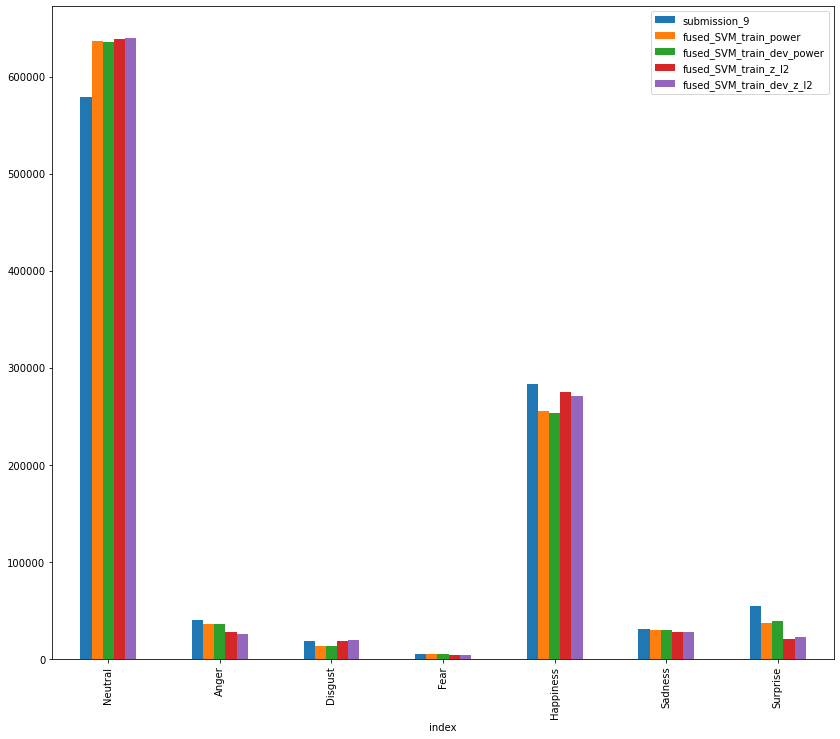

In [7]:
all_models_distributions=pd.concat([model_3_distribution,model_4_distribution,model_PANN_distribution,model_1D_distribution,
                                    model_linearSVM_distribution_train_power_distribution,model_linearSVM_distribution_train_dev_power_distribution,
                                    model_linearSVM_distribution_train_z_l2_distribution,model_linearSVM_distribution_train_dev_z_l2_distribution, submission_9_distribution,
                                    model_fused_SVM_predictions_train_power_distribution,model_fused_SVM_predictions_train_dev_power_distribution,
                                    model_fused_SVM_predictions_train_z_l2_distribution,model_fused_SVM_predictions_train_dev_z_l2_distribution ], axis=1)
all_models_distributions.index=['Neutral','Anger','Disgust','Fear','Happiness','Sadness','Surprise']
all_models_distributions=all_models_distributions.reset_index()


#all_models_distributions.plot(x="index", y=['submission_9','linearSVM_power_only_train','linearSVM_power_train_dev',
#                                                'linearSVM_z_l2_only_train','linearSVM_z_l2_dev_train'], kind="bar",figsize=(14,12)).get_figure().savefig('distribution.png')

all_models_distributions.plot(x="index", y=['submission_9','fused_SVM_train_power','fused_SVM_train_dev_power',
                                                'fused_SVM_train_z_l2','fused_SVM_train_dev_z_l2'], kind="bar",figsize=(14,12)).get_figure().savefig('distribution.png')
plt.show()